### Notes on the Data:

The following notebook expects to find all data files in a folder ``data/data_ps3`` but you may also simply pass the path of your data folder to the ``load_data`` function; this will work with unix and windows paths. Similarly, the notebook expects the ``xlsx`` file containing unemployment rates from the Bureau of Labor Statistics to be located at ``data/data_ps3/bls.xlsx``. But this path can also be set in the ``load_data`` function.

To download the data on a unix machine open your favorite terminal emulator and run the following commands line by line.

```console
$ for year in {1990..2017}; do
$ wget "http://ceprdata.org/wp-content/cps/data/cepr_org_${year}.zip"
$ done

$ mkdir data_ps3
$ mv *.zip data_ps3
$ cd data_ps3

$ unzip *.zip
$ rm *.zip
```

### Preliminaries:

In [1]:
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from functools import partial

sns.set_style("whitegrid")
sns.set_palette("muted")

In [2]:
COLUMNS = [
    "year",
    "month",
    "fnlwgt",
    "empl",
    "unem",
    "female",
    "wbhao",
    "educ",
    "age",
]

STR_MONTH_TO_INT = {(v, k) for k, v in enumerate(calendar.month_abbr)}

### Helper Functions:

In [3]:
def convert_year_month_to_date(df):
    date = df["year"].astype(str) + "-" + df["month"].astype(str)
    date = pd.to_datetime(date)
    df["date"] = date
    df = df.drop(["year", "month"], axis=1).set_index("date")
    return df

In [4]:
def load_data(cps_path="data/data_ps3", bls_path="data/data_ps3/bls.xlsx"):
    """Load CPS and BLS data."""
    path = Path(cps_path)

    merged_path = path / "cps_merged.pkl"
    if merged_path.is_file():
        cps = pd.read_pickle(merged_path)
    else:
        df_list = []
        for year in range(1990, 2018):
            df = pd.read_stata(
                path / f"cepr_org_{year}.dta", convert_categoricals=False
            )
            df = df[COLUMNS]
            df_list.append(df)
        cps = pd.concat(df_list, axis=0)
        cps[["empl", "unem", "educ"]] = cps[["empl", "unem", "educ"]].astype("Int64")
        cps = convert_year_month_to_date(cps)

    bls = pd.read_excel(bls_path, skiprows=11).rename(columns={"Year": "year"})
    bls = bls.melt(id_vars="year", var_name="month", value_name="bls")
    bls["month"] = bls["month"].replace(STR_MONTH_TO_INT)

    return cps, bls

In [5]:
def filter_data(df):
    df = df.query("age >= 16")
    df = df.dropna(subset=["empl", "unem"])
    return df

In [6]:
def compute_unemployment_rate_cps(df_filtered, covariate=None, replace_groupby=None):
    covariate = [] if covariate is None else covariate
    covariate = covariate if isinstance(covariate, list) else [covariate]
    keys = COLUMNS[:3]

    def _ws(_data):
        """Weighted sum."""
        weighted_sum = _data["fnlwgt"].dot(_data.drop("fnlwgt", axis=1))
        return weighted_sum

    gp_statement = (
        ["year", "month"] + covariate if replace_groupby is None else replace_groupby
    )
    gp = df_filtered.groupby(gp_statement)
    summed = gp[["unem", "empl", "fnlwgt"]].apply(_ws)
    summed.columns.name = None
    summed["labor_force"] = summed["empl"] + summed["unem"]
    summed["unem_rate"] = summed["unem"] / summed["labor_force"]

    df = summed[["unem_rate"]].rename(columns={"unem_rate": "cps"}).reset_index()
    return df

In [7]:
def merge_cps_and_bls(cps, bls):
    df = pd.concat((cps, bls), axis=1)
    df = (
        df.reset_index()
        .melt(id_vars=["date"], var_name="data_set", value_name="unem_rate")
        .set_index("date")
    )
    return df

### Comparison of CPS and BLS:

In [8]:
cps_raw, bls_raw = load_data()

cps_filtered = filter_data(cps_raw)
cps = compute_unemployment_rate_cps(cps_filtered)
cps = convert_year_month_to_date(cps)

bls = convert_year_month_to_date(bls_raw)
bls /= 100

df = merge_cps_and_bls(cps, bls)

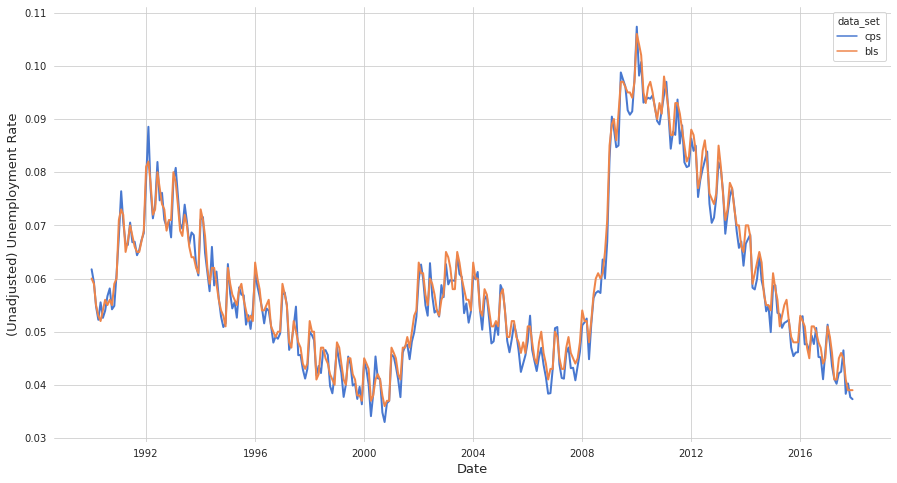

In [9]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(
    x="date",
    y="unem_rate",
    hue="data_set",
    data=df,
    ax=ax,
    linewidth=2,
    legend="brief",
)

ax.set(ylabel="(Unadjusted) Unemployment Rate", xlabel="Date")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
plt.show()

## Unemployment Rate by Group:

In [10]:
mapper = {
    "wbhao": {1: "white", 2: "black", 3: "asian", 4: "native", 5: "hispanic",},
    "female": {1: "female", 0: "male",},
    "educ": {1: "low", 2: "low-medium", 3: "medium", 4: "medium-high", 5: "high",},
}

In [11]:
covariates = ["female", "educ", "wbhao"]

dfs = {}
for covariate in covariates:
    df_tmp = compute_unemployment_rate_cps(cps_filtered, covariate)
    df_tmp = convert_year_month_to_date(df_tmp)
    df_tmp = df_tmp.replace(mapper[covariate])
    dfs[covariate] = df_tmp

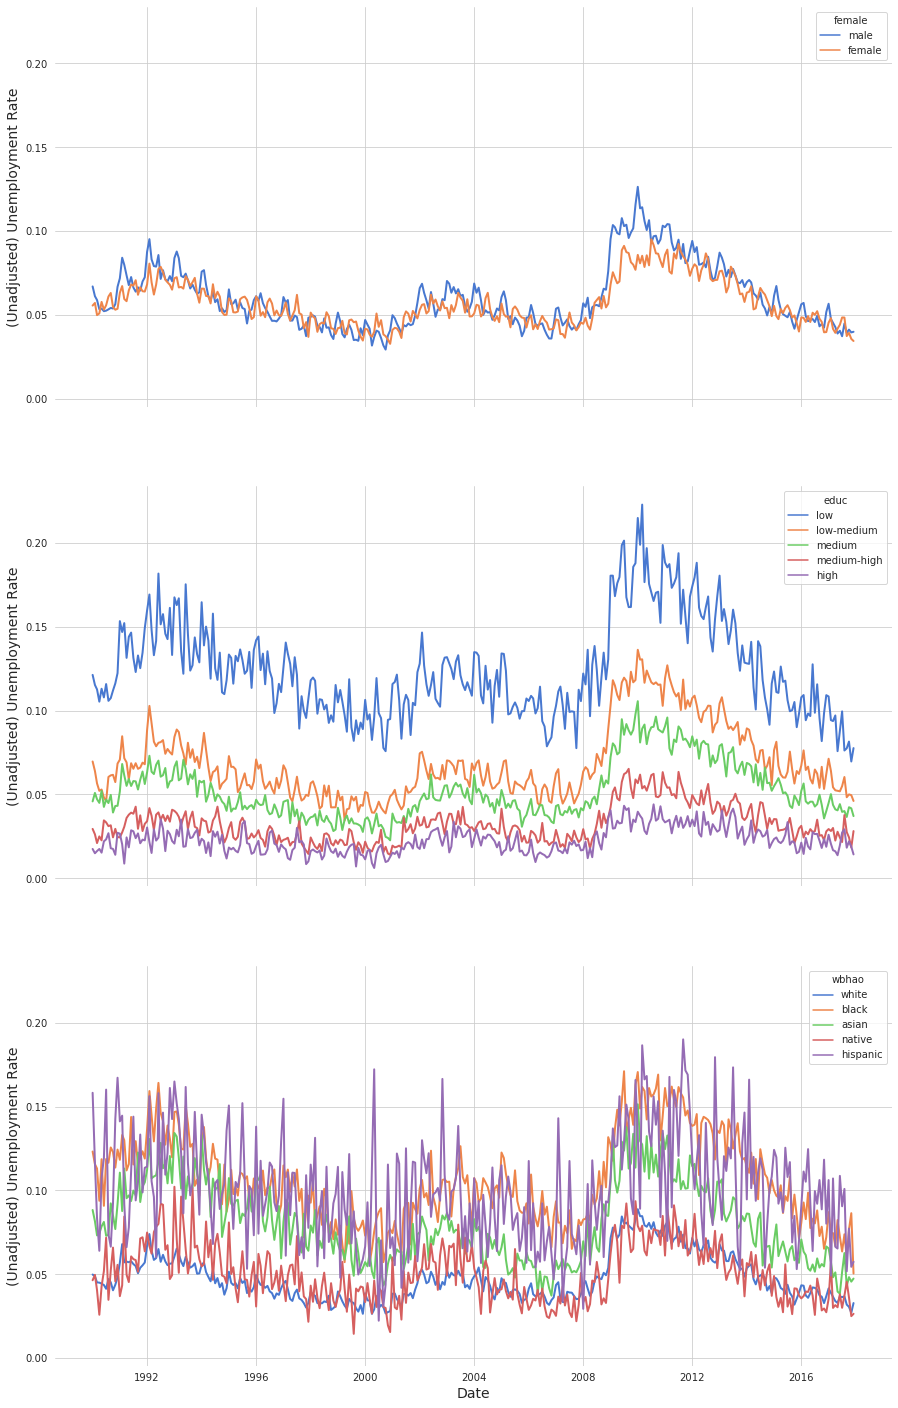

In [12]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(15, 25))

for i, (covariate, _df) in enumerate(dfs.items()):
    ax = sns.lineplot(
        x="date",
        y="cps",
        hue=covariate,
        data=_df,
        ax=axs[i],
        linewidth=2,
        legend="brief",
    )

    ax.set(ylabel="(Unadjusted) Unemployment Rate", frame_on=False)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

plt.setp(axs[-1], xlabel="Date")
plt.show()

### Unemployment Rate by Age:

In [13]:
df_age = cps_filtered.query("20 <= age <= 60")

df_age = compute_unemployment_rate_cps(df_age, replace_groupby=["age"])

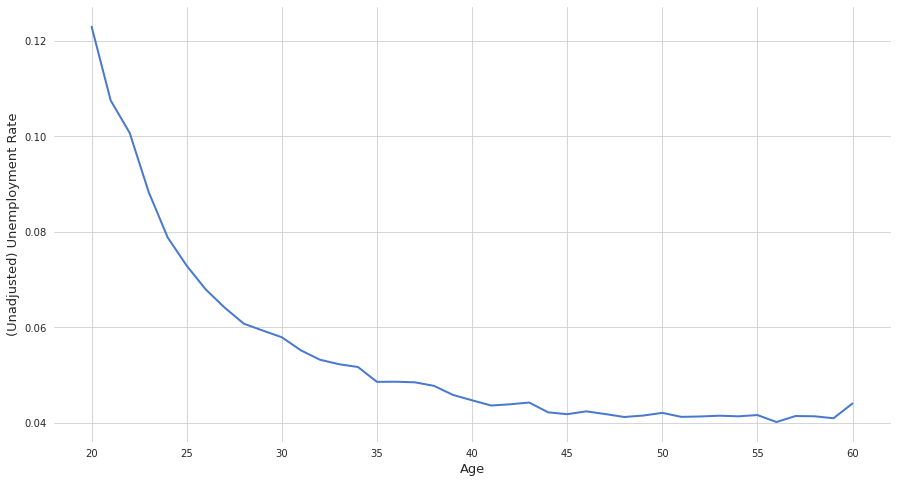

In [14]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(
    x="age", y="cps", data=df_age, ax=ax, linewidth=2,
)

ax.set(ylabel="(Unadjusted) Unemployment Rate", xlabel="Age")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
plt.show()